# Salient Maps

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from wilds import get_dataset
from utils.datasets import BinaryDataset, SpuCoDogsDataset, CheXpertBinaryDataset
from torchvision.datasets import CelebA

from collections import OrderedDict

: 

In [ ]:
dataset_path = '../SCRATCH'
models_path = '../SCRATCH/CFE_models'
seed = 10
comb_nat_pert = False
percentage = 10

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

WaterBirds_transform = transforms.Compose([
        transforms.Resize((int(224 * (256 / 224)), int(224 * (256 / 224)),)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

SpuCo_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

celebA_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
def saliency(img, label, model, mode='Original', dataset='waterbirds', sample_idx=None):

    assert dataset in ['waterbirds', 'spucodogs','celebA','chexpert']
    plt.figure(figsize=(8, 4))
    
    # Disable gradient calculation for model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Prepare input image
    input = img.detach()
    input.unsqueeze_(0)  # Add batch dimension
    input.requires_grad = True
    
    # Set model to evaluation mode
    model.zero_grad()
    model.eval()

    # Forward pass
    preds = model(input)
    #score = preds * label
    # Get score for target class
    score, _ = torch.max(preds, 1)
    
    
    # Backward pass to get gradients
    score.backward()
    
    # Get maximum absolute gradient across color channels
    sal, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    # Normalize saliency map to [0,1] range
    sal = (sal - sal.min())/(sal.max()-sal.min())
    
    # Get original image without normalization
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    if dataset == 'waterbirds':
        predicted_label = "WaterBird" if preds.argmax(dim=1).item() == 1 else "LandBird"
        Class = "LandBird" if label.item() == 0 else "WaterBird"
    elif dataset == 'spucodogs':
        predicted_label = "Small Dog" if preds.argmax(dim=1).item() == 1 else "Big Dog"
        Class = "Big Dog" if label == 0 else "Small Dog"
    elif dataset == 'celebA':
        predicted_label = "Blonde" if preds.argmax(dim=1).item() == 1 else "Not Blonde"
        Class = "Not Blonde" if label[9].item() == 0 else "Blonde"
    elif dataset == 'chexpert':
        predicted_label = "No Findings" if preds.argmax(dim=1).item() == 1 else "Findings Found"
        Class = "No Findings" if label[0].item() == 1 else "Findings Found"

    orig_img_path = f'./results/saliency_maps/{dataset}_{mode}_{Class}_sample_idx_{sample_idx}.jpg'
    sal_map_path = f'./results/saliency_maps/{dataset}_{mode}_{Class}_sample_idx_{sample_idx}_saliency_map.jpg'
    combined_path = f'./results/saliency_maps/{dataset}_{mode}_{Class}_sample_idx_{sample_idx}_combined.jpg'

    print(f'Mode: {mode}')
    print(f'Dataset: {dataset}')
    print(f"Predicted label: {predicted_label}, True label: {Class}")

    # Plot original image
    plt.subplot(1, 2, 1, title=f'Original Image')
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    
    # Plot saliency map
    plt.subplot(1, 2, 2, title=f'{mode} Saliency')
    plt.imshow(sal.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(combined_path, bbox_inches='tight', dpi=300)
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.imshow(sal.numpy(), cmap='hot')
    plt.axis('off')
    plt.savefig(sal_map_path, bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.savefig(orig_img_path, bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()


In [4]:
def prep_model(model_path, mode='Original', dataset='waterbirds'):
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        state_dict = torch.load(model_path)
    elif mode == 'Original':
        state_dict = torch.load(model_path)
    else:
        NotImplementedError
        
    state_dict = OrderedDict((k.replace('model.resnet.', '', 1), v) for k, v in state_dict.items())
    
    model = torchvision.models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(state_dict=state_dict)
    model.to('cpu')
    return model

### For WaterBirds Dataset

In [5]:
main_dataset = get_dataset(dataset="waterbirds", download=False,root_dir='../SCRATCH/')
data = main_dataset.get_subset("val", transform=WaterBirds_transform)
data = BinaryDataset(data,which_dataset='waterbirds')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].


Mode: Original
Dataset: waterbirds
Predicted label: LandBird, True label: LandBird


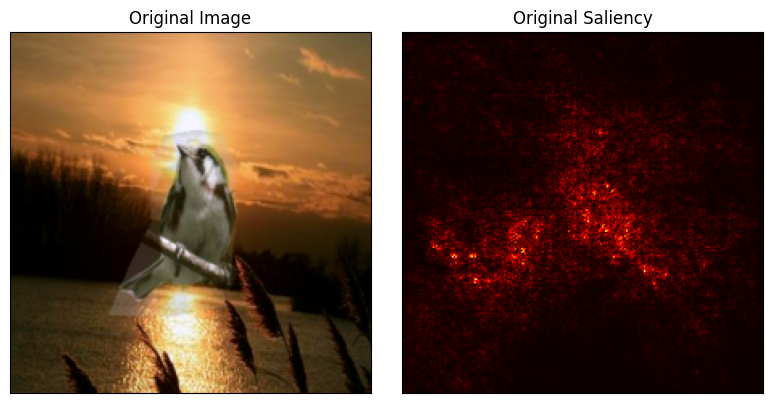

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].


Mode: L2
Dataset: waterbirds
Predicted label: LandBird, True label: LandBird


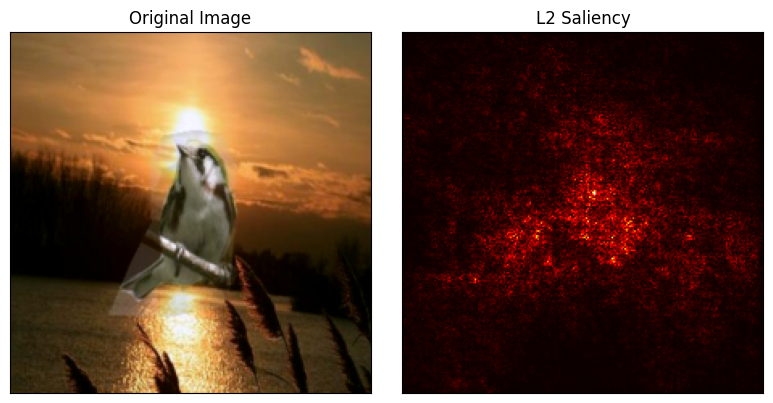

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].


Mode: Linf
Dataset: waterbirds
Predicted label: LandBird, True label: LandBird


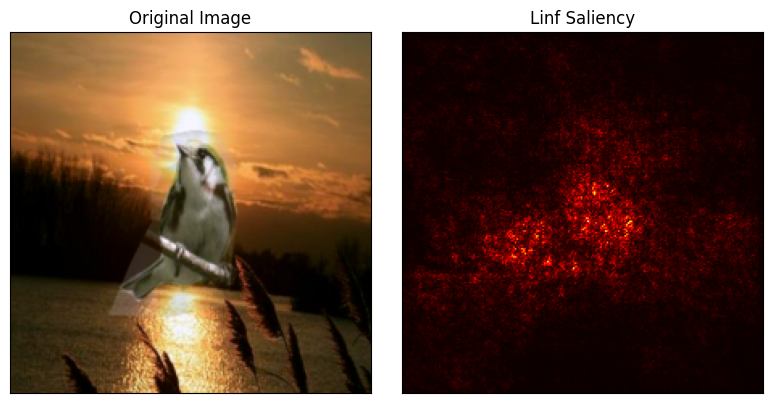

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].


Mode: GDPR_CFE
Dataset: waterbirds
Predicted label: LandBird, True label: LandBird


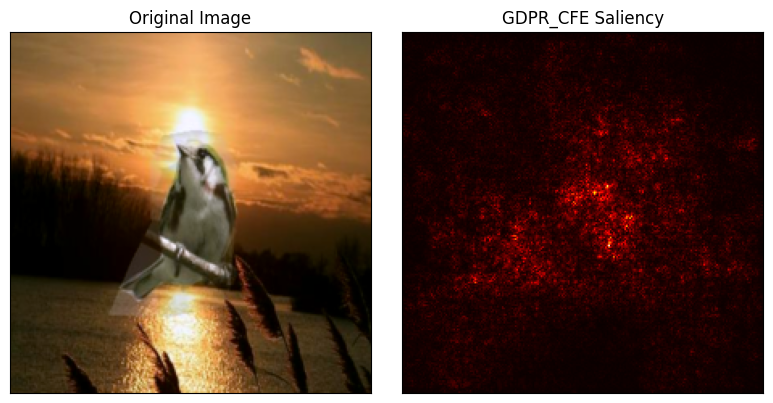

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].


Mode: SCFE
Dataset: waterbirds
Predicted label: LandBird, True label: LandBird


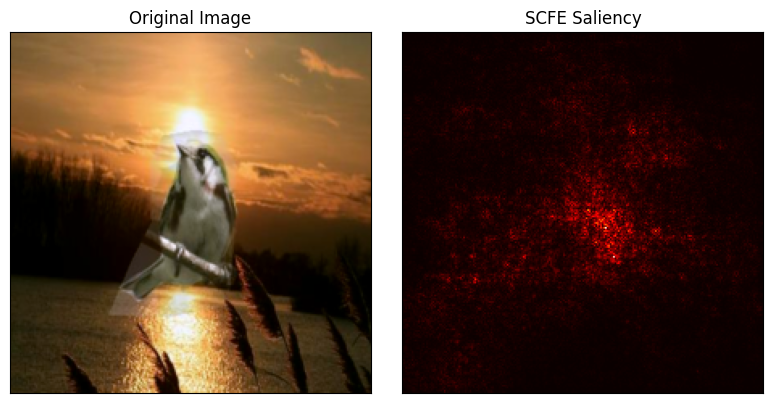

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0614222].


In [ ]:
sample_idx = 982 # maybe 129, 345, 433
mode_list = ['Original', 'L2', 'Linf', 'GDPR_CFE','SCFE']

for mode in mode_list:
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        model = prep_model(model_path=f"{models_path}/WaterBirds_{mode}_seed_{seed}_percentage_{percentage}.pt", mode=mode) if comb_nat_pert \
        else prep_model(model_path=f"{models_path}/WaterBirds_{mode}_seed_{seed}.pt")
    elif mode == 'Original':
        model = prep_model(model_path=f"{models_path}/WaterBirds_trained_model_seed_{seed}.pt", mode=mode)
    else:
        NotImplementedError

    saliency(data[sample_idx][0], data[sample_idx][1], model, mode, dataset='waterbirds', sample_idx=sample_idx)

### For SpuCo Dogs Dataset

In [ ]:
spuco_test_dataset = SpuCoDogsDataset(root='../SCRATCH/spuco_dogs/test', transform=SpuCo_transform)

2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].


Mode: Original
Dataset: spucodogs
Predicted label: Big Dog, True label: Big Dog


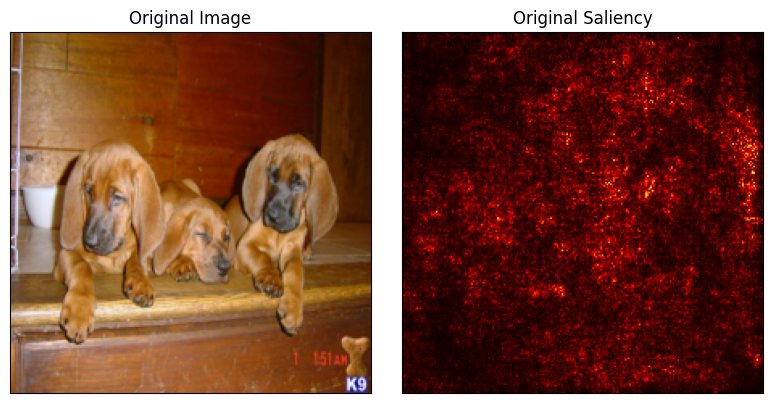

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].


Mode: L2
Dataset: spucodogs
Predicted label: Big Dog, True label: Big Dog


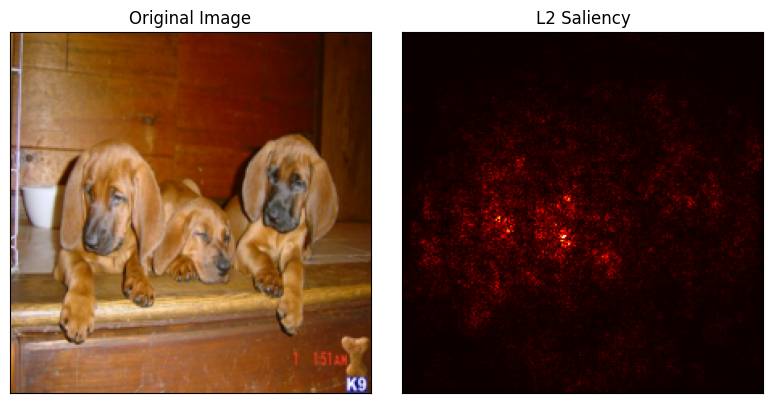

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].


Mode: Linf
Dataset: spucodogs
Predicted label: Big Dog, True label: Big Dog


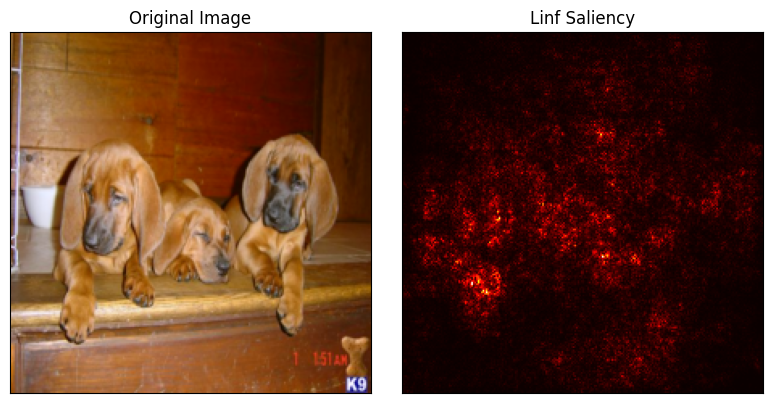

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].


Mode: GDPR_CFE
Dataset: spucodogs
Predicted label: Big Dog, True label: Big Dog


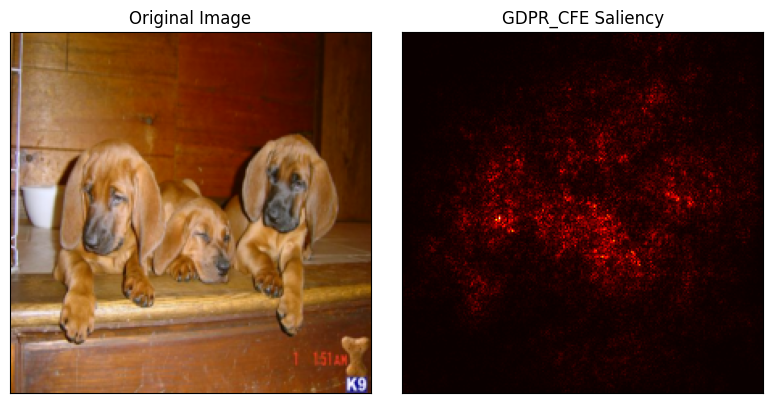

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].


Mode: SCFE
Dataset: spucodogs
Predicted label: Big Dog, True label: Big Dog


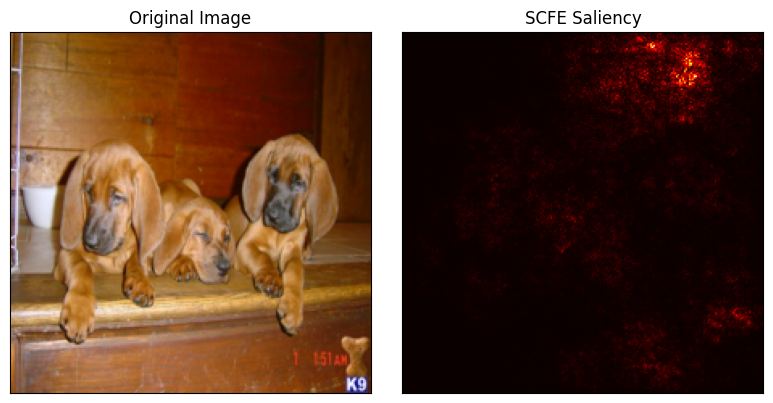

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0525333].


In [ ]:
sample_idx = 410 # maybe 1300, 100, 160, 230, 270, 280, 380, 385, 410
mode_list = ['Original', 'L2', 'Linf', 'GDPR_CFE', 'SCFE']

for mode in mode_list:
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        model = prep_model(model_path=f"{models_path}/SpuCO_dogs_{mode}_seed_{seed}_percentage_{percentage}.pt", mode=mode) if comb_nat_pert \ 
        else prep_model(model_path=f"{models_path}/SpuCO_dogs_{mode}_seed_{seed}.pt", mode=mode)
    elif mode == 'Original':
        model = prep_model(model_path=f"{models_path}/SpuCO_dogs_trained_model_seed_{seed}.pt", mode=mode)
    else:
        NotImplementedError
    
    saliency(spuco_test_dataset[sample_idx][0], spuco_test_dataset[sample_idx][1], model, mode, dataset='spucodogs', sample_idx=sample_idx)

# For CelebA dataset

In [6]:
celebA_test_set = CelebA(root='../SCRATCH', split='test', transform=celebA_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].


Mode: Original
Dataset: celebA
Predicted label: Not Blonde, True label: Not Blonde


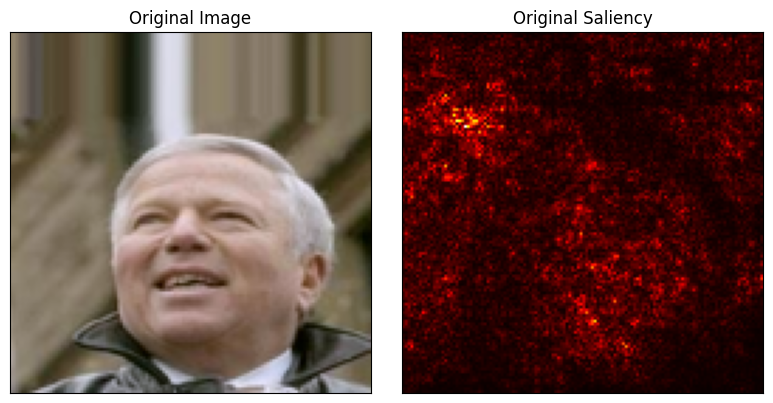

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].


Mode: L2
Dataset: celebA
Predicted label: Not Blonde, True label: Not Blonde


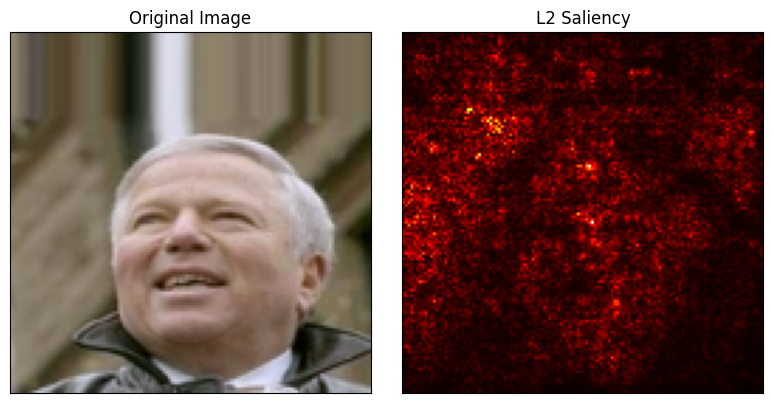

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].


Mode: GDPR_CFE
Dataset: celebA
Predicted label: Not Blonde, True label: Not Blonde


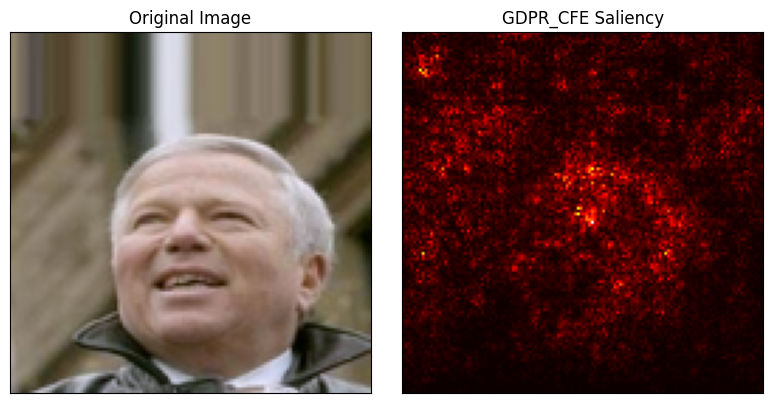

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].


Mode: Linf
Dataset: celebA
Predicted label: Not Blonde, True label: Not Blonde


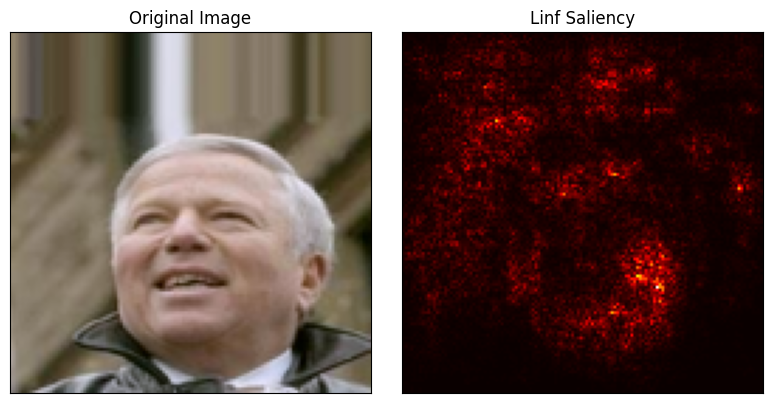

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04968887..0.9769779].


In [15]:
sample_idx = 560 # maybe 129, 345, 433
mode_list = ['Original','L2','GDPR_CFE','Linf']#, 'L2', 'Linf', 'GDPR_CFE','SCFE']

for mode in mode_list:
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        model = prep_model(model_path=f"../SCRATCH/CFE_models/celebA_{mode}", mode=mode, dataset='celebA')
    elif mode == 'Original':
        model = prep_model(model_path=f"../SCRATCH/CFE_models/celebA_trained_model.pt", mode=mode)
    else:
        NotImplementedError

    saliency(celebA_test_set[sample_idx][0], celebA_test_set[sample_idx][1], model, mode, dataset='celebA', sample_idx=sample_idx)

# For CheXpert dataset

In [5]:
chexpert_val_set = CheXpertBinaryDataset(csv_path='../SCRATCH/CheXpert-v1.0-small/valid.csv',
                                         image_root_path='../SCRATCH',
                                         transform=transform
                    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


Mode: Original
Dataset: chexpert
Predicted label: Findings Found, True label: Findings Found


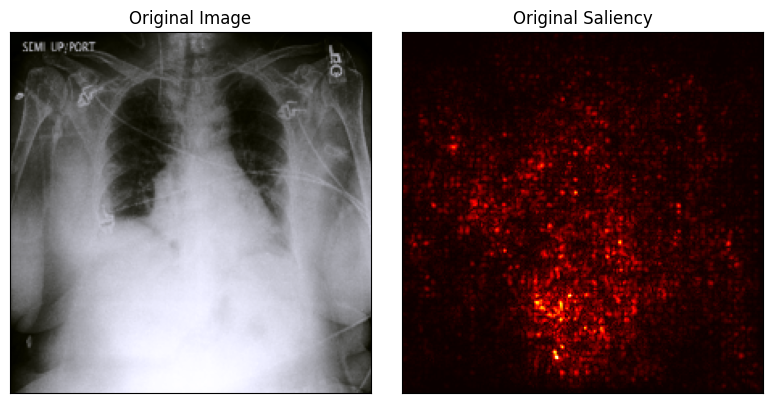

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


In [23]:
sample_idx = 125
mode_list = ['Original']#, 'L2', 'Linf', 'GDPR_CFE','SCFE']

for mode in mode_list:
    if mode in ['L2', 'Linf', 'GDPR_CFE', 'SCFE']:
        model = prep_model(model_path=f"../SCRATCH/CFE_models/CheXpert_{mode}", mode=mode, dataset='chexpert')
    elif mode == 'Original':
        model = prep_model(model_path=f"../SCRATCH/CFE_models/CheXpert_trained_model.pt", mode=mode, dataset='chexpert')
    else:
        NotImplementedError

    saliency(chexpert_val_set[sample_idx][0], chexpert_val_set[sample_idx][1], model, mode, dataset='chexpert', sample_idx=sample_idx)